In [1]:
import os, glob
import matplotlib.pyplot as plt

import TCAV_support as ts
import Model_support as ms

# ..........torch imports............
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# .... Captum imports..................
from captum.attr import LayerIntegratedGradients
from captum.concept import TCAV

cudnn.benchmark = True
plt.ion()   # interactive mode

# GLobal values
COLAB = False

In [2]:
# Preliminary work for fine tuning the model.
data_dir = 'data/tcav/image/imagenet'
data_transforms = ms.return_data_transforms()

image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
# Preliminary work for setting up concepts
concepts_path = "data/tcav/image/concepts/"

# Selected concepts
stripes_concept = ts.assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = ts.assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = ts.assemble_concept("dotted", 2, concepts_path=concepts_path)

# Random concepts
random_0_concept = ts.assemble_concept("random_0", 3, concepts_path=concepts_path)
random_1_concept = ts.assemble_concept("random_1", 4, concepts_path=concepts_path)


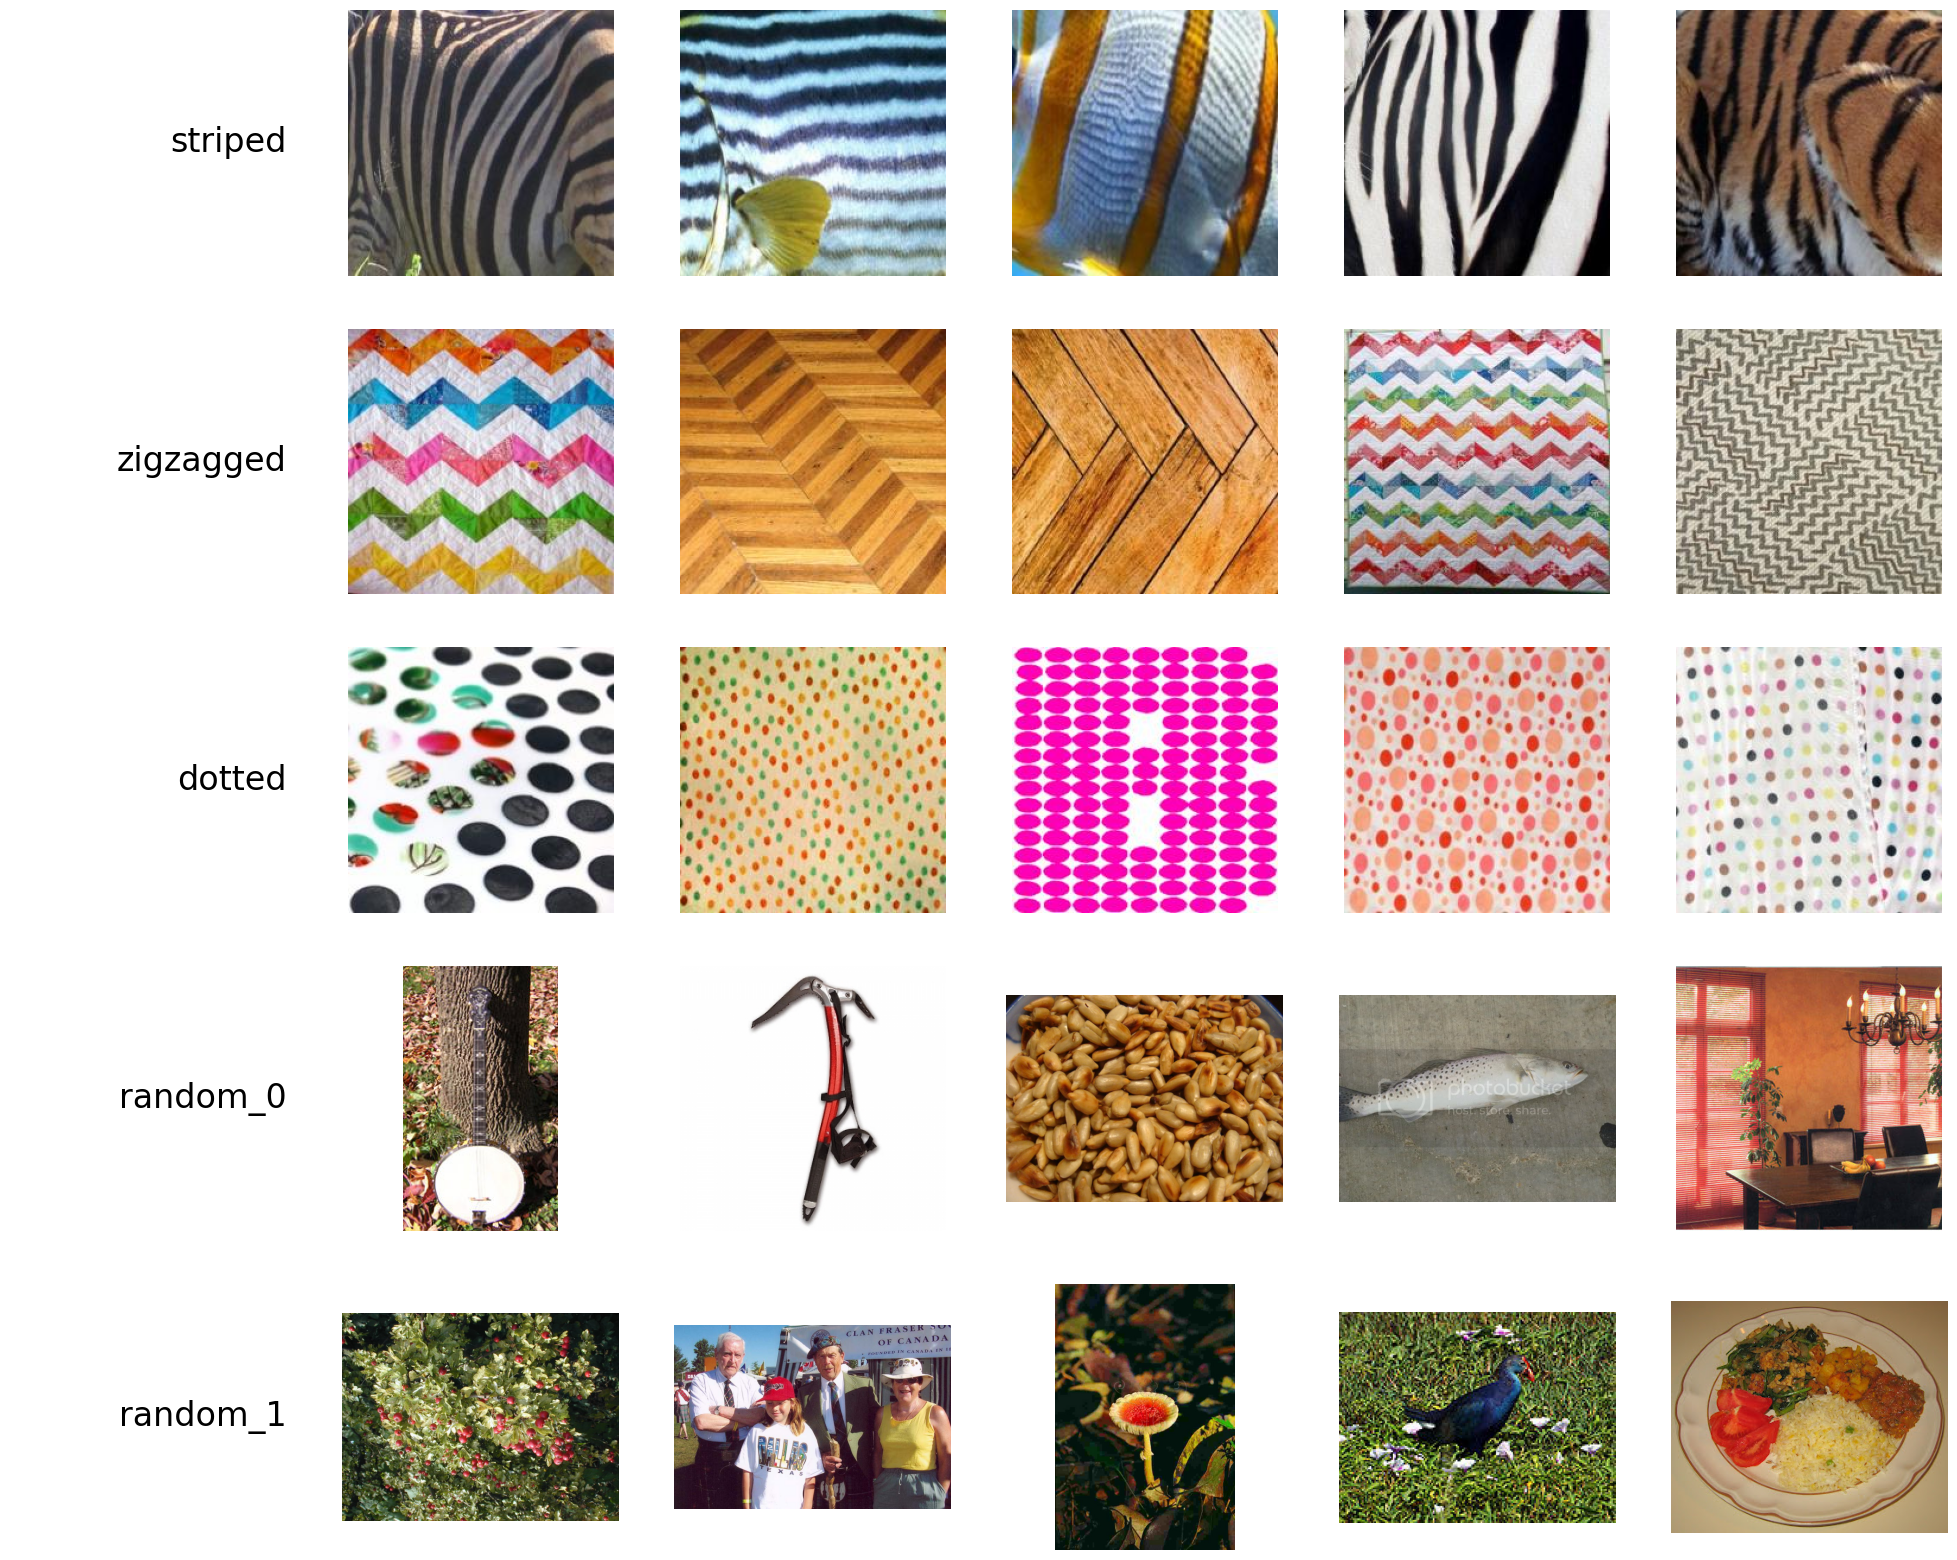

In [4]:
# Visualization of various concepts
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [4]:
# Preparing the model
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)


# Send model to CUDA device if it exists
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Select the layers for interpretation.
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

D:\git\COMP-5900\venv\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [10]:
experimental_set_rand = [[stripes_concept, zigzagged_concept, dotted_concept]]

data/tcav/image/imagenet/val/zebra
data/tcav/image/imagenet/val/ants
data/tcav/image/imagenet/val/bees


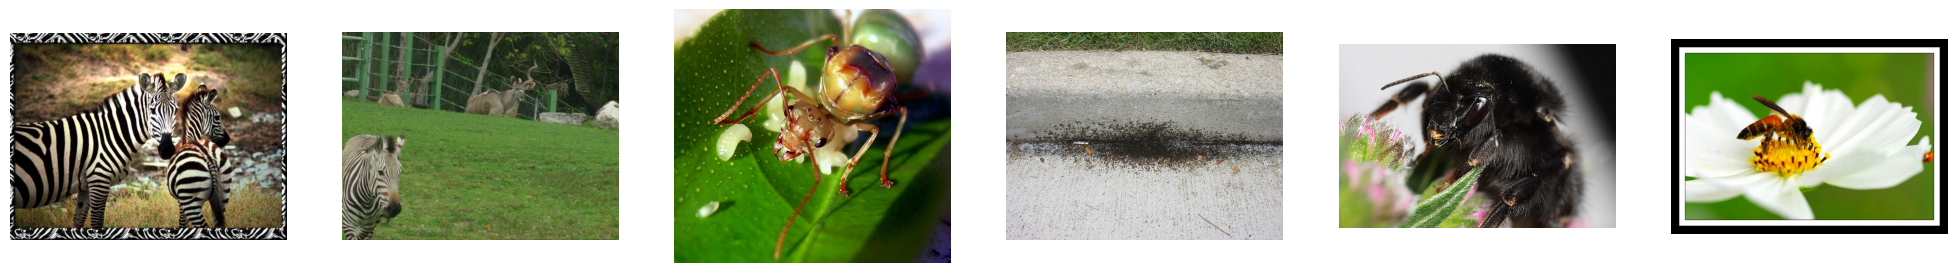

In [7]:
# Load sample images from folder
zebra_imgs = ts.load_image_tensors('val/zebra', transform=False)
ant_imgs = ts.load_image_tensors('val/ants', transform=False)
bee_imgs = ts.load_image_tensors('val/bees', transform=False)

# Visualize some of the images
fig, axs = plt.subplots(1, 6, figsize = (25, 5))
axs[0].imshow(zebra_imgs[40])
axs[1].imshow(zebra_imgs[41])
axs[2].imshow(ant_imgs[34])
axs[3].imshow(ant_imgs[31])
axs[4].imshow(bee_imgs[30])
axs[5].imshow(bee_imgs[31])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')

plt.show()

[[Concept(0, 'striped'), Concept(1, 'zigzagged'), Concept(2, 'dotted')]]


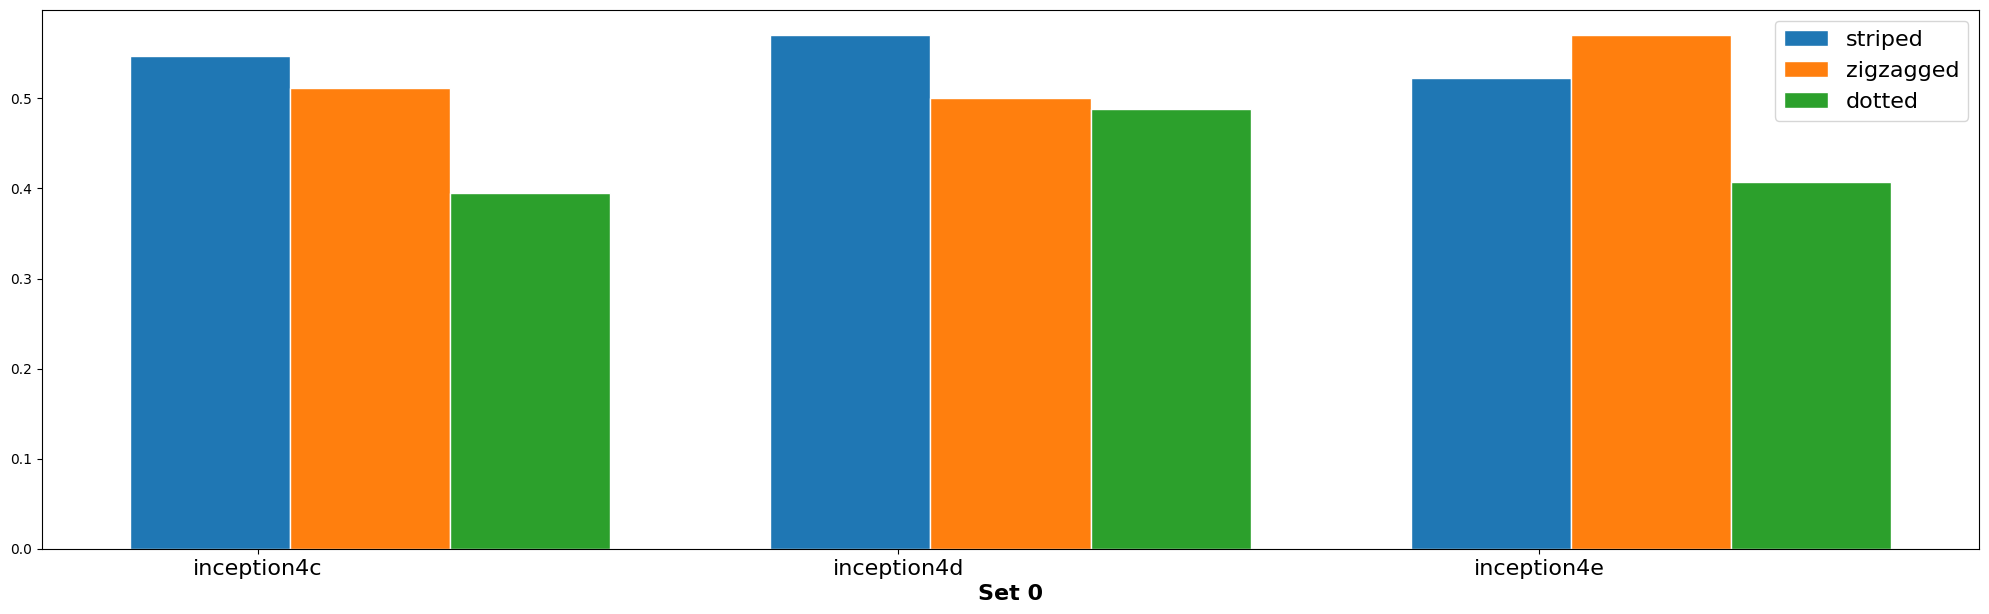

In [12]:
model.to("cpu")
# Load sample images from folder
zebra_tensors = torch.stack([ts.transform(img) for img in zebra_imgs])
ant_tensors = torch.stack([ts.transform(img) for img in ant_imgs])
bee_tensors = torch.stack([ts.transform(img) for img in bee_imgs])

if COLAB:
    model.to(device=device)
    zebra_tensors.to(device)
print(experimental_set_rand)

# zebra, ant and bee class index
zebra_ind, ant_ind, bee_ind = 340, 310, 309

tcav_scores_w_random_zebra = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
# tcav_scores_w_random_ant = mytcav.interpret(inputs=ant_tensors,
#                                         experimental_sets=experimental_set_rand,
#                                         target=ant_ind,
#                                         n_steps=5,
#                                        )
# tcav_scores_w_random_bee = mytcav.interpret(inputs=bee_tensors,
#                                         experimental_sets=experimental_set_rand,
#                                         target=bee_ind,
#                                         n_steps=5,
#                                        )

ts.plot_tcav_scores(experimental_set_rand, tcav_scores_w_random_zebra, layers)

In [16]:
# Here is where we want to fine tune the model.
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))
print(class_names)

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

['ants', 'bees', 'zebra']


In [14]:
model_ft = ms.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device=device, dataloaders=dataloaders,
                          dataset_sizes=dataset_sizes, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6197 Acc: 0.6311
val Loss: 0.3356 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4576 Acc: 0.7951
val Loss: 0.2319 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4642 Acc: 0.7828
val Loss: 0.2108 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4935 Acc: 0.7869
val Loss: 0.2002 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3756 Acc: 0.8525
val Loss: 0.1763 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3935 Acc: 0.8361
val Loss: 0.1684 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4461 Acc: 0.7951
val Loss: 0.2236 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4340 Acc: 0.7992
val Loss: 0.1746 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2568 Acc: 0.8852
val Loss: 0.1671 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.2830 Acc: 0.9057
val Loss: 0.1557 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2621 Acc: 0.8648
val Loss: 0.1614 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2914 Acc: 0.8852
val Loss: 0.1549 Acc: 0.9477

Ep

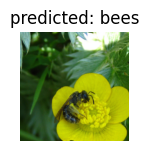

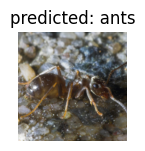

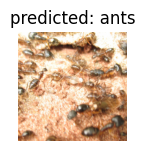

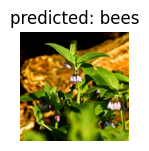

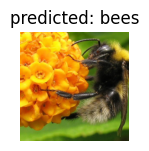

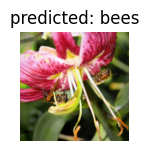

In [15]:
ms.visualize_model(model_ft, device=device, dataloaders=dataloaders, class_names=class_names)

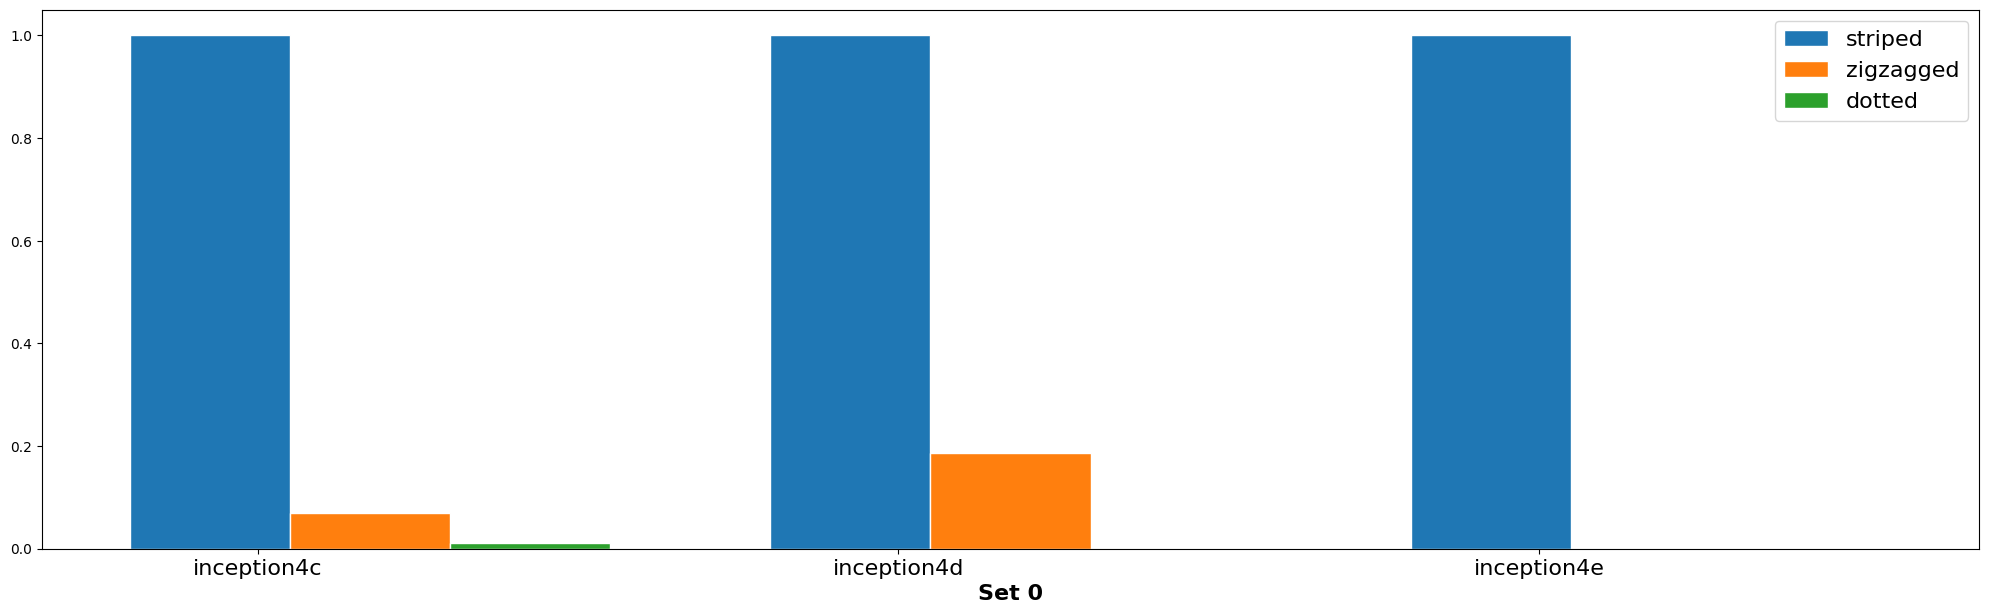

In [17]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]

tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)

ts.plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, layers)